In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import esmtools as et
from esmtools import stats

import shapefile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gp
import regionmask
import matplotlib.patches as mpatches

In [2]:
# Open dataset for DIC
dir = '/home/jovyan/SOARS_2021/Data/CESM2/'
fn_dissic = 'dissic_Omon_CESM2_omip2_r1i1p1f1_gr_030601-036612.nc'

data_dissic = xr.open_dataset(dir+fn_dissic)
data_dissic 

/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'dissic' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (d2: 2, lat: 180, lev: 33, lon: 360, time: 732)
Coordinates:
  * time       (time) object 0306-01-15 12:00:00 ... 0366-12-15 12:00:00
  * lev        (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object ...
    lev_bnds   (lev, d2) float64 ...
    lat_bnds   (lat, d2) float64 ...
    lon_bnds   (lon, d2) float64 ...
    dissic     (time, lev, lat, lon) float32 ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            OMIP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    case_id:                1540
    ...                     ...
    tracking_id:            hdl:21.14100/db4fc2a0-d7df-4ac5-acb9-d7ce613c4851
    variable_id:            dissic
    variant_info:           CMIP6 omip2 experiment (JRA forcing) with interac...
    variant_label:          r1i1p1f1
    source_type:            OGCM BGC
    comment:                Experiment run for 6 cycles of 1958-2018 JRA55 fo...

In [3]:
# Adjust the time series 
data_dissic['time'] = np.arange('1958-01-01','2019-01-01',dtype = 'datetime64[M]')

In [4]:
data_dissic['time'] = pd.date_range("1958-01", "2018-12", freq="MS")
dissic = data_dissic['dissic']
dissic = dissic.sel(lon=slice(190,270),lat=slice(-10,70), lev=0)

In [5]:
# Adjust the units from mol / m^3 to mmol / m^3 
dissic = dissic * 1000

In [6]:
# remove long term trend for each grid cell
var = stats.rm_poly(dissic,order=2,dim='time',nan_policy='drop')
#var = dissic 

In [7]:
# 1982-2010 period
base = var.sel(time=slice('1982-01','2010-12'))
dissic_base = base

In [8]:
# Blob period
blob = var.sel(time=slice('2013-07','2016-06'))
tos_blob = blob

In [9]:
# Difference between the two periods
blob_anom = blob.groupby('time.month') - base.groupby('time.month').mean()

In [10]:
# Resample to two month resolution
cesm = blob_anom.resample(time='2M').mean()
cesm

<xarray.DataArray (lat: 80, lon: 80, time: 19)>
array([[[-3.22705503e+00, -6.17546333e+00, -1.26579891e+01, ...,
         -8.00392819e+00, -1.79370366e+01, -3.09246742e+01],
        [-3.15183445e+00, -5.86337053e+00, -1.31115221e+01, ...,
         -1.00363219e+01, -2.05712409e+01, -3.31966985e+01],
        [-2.68451107e+00, -5.79848482e+00, -1.34754585e+01, ...,
         -1.22697829e+01, -2.34384040e+01, -3.47044136e+01],
        ...,
        [ 7.06427723e+00,  5.66227056e+00,  4.78951634e+00, ...,
         -1.58472037e+01, -1.87336757e+01, -1.74448151e+01],
        [ 6.84094869e+00,  5.31427165e+00,  4.75366785e+00, ...,
         -1.64610596e+01, -1.92536311e+01, -1.69719472e+01],
        [ 6.25346583e+00,  4.90040822e+00,  4.79738475e+00, ...,
         -1.76703552e+01, -1.93617095e+01, -1.73661912e+01]],

       [[-7.60765776e-01, -4.68326449e+00, -1.11294726e+01, ...,
         -2.02059760e+01, -2.96811561e+01, -3.82750565e+01],
        [-7.88281277e-01, -4.52094722e+00, -1.11371369e+01, ...,
         -2.22132450e+01, -3.24383618e+01, -4.01259043e+01],
        [-5.71229298e-01, -4.56652998e+00, -1.09635416e+01, ...,
         -2.39546602e+01, -3.51601928e+01, -4.13314629e+01],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-4.89355728e+00,  6.52557040e+00,  6.53045743e+00, ...,
         -1.24859592e+01, -1.75707985e+01, -4.45677348e+01],
        [-8.28827545e-03,  5.65966633e+00,  5.07973066e+00, ...,
         -1.40561388e+01, -1.85736167e+01, -4.25720883e+01],
        [ 1.42763316e+00,  4.77479734e+00,  3.80284240e+00, ...,
         -1.49400037e+01, -1.89705035e+01, -3.65382814e+01],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 2.24062926e+01,  2.70553277e+01,  5.76827948e+00, ...,
          9.56078197e-01,  1.11406542e+00, -3.88668638e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-31 2013-09-30 ... 2016-07-31
    lev      float64 0.0
  * lat      (lat) float64 -9.5 -8.5 -7.5 -6.5 -5.5 ... 65.5 66.5 67.5 68.5 69.5
  * lon      (lon) float64 190.5 191.5 192.5 193.5 ... 266.5 267.5 268.5 269.5

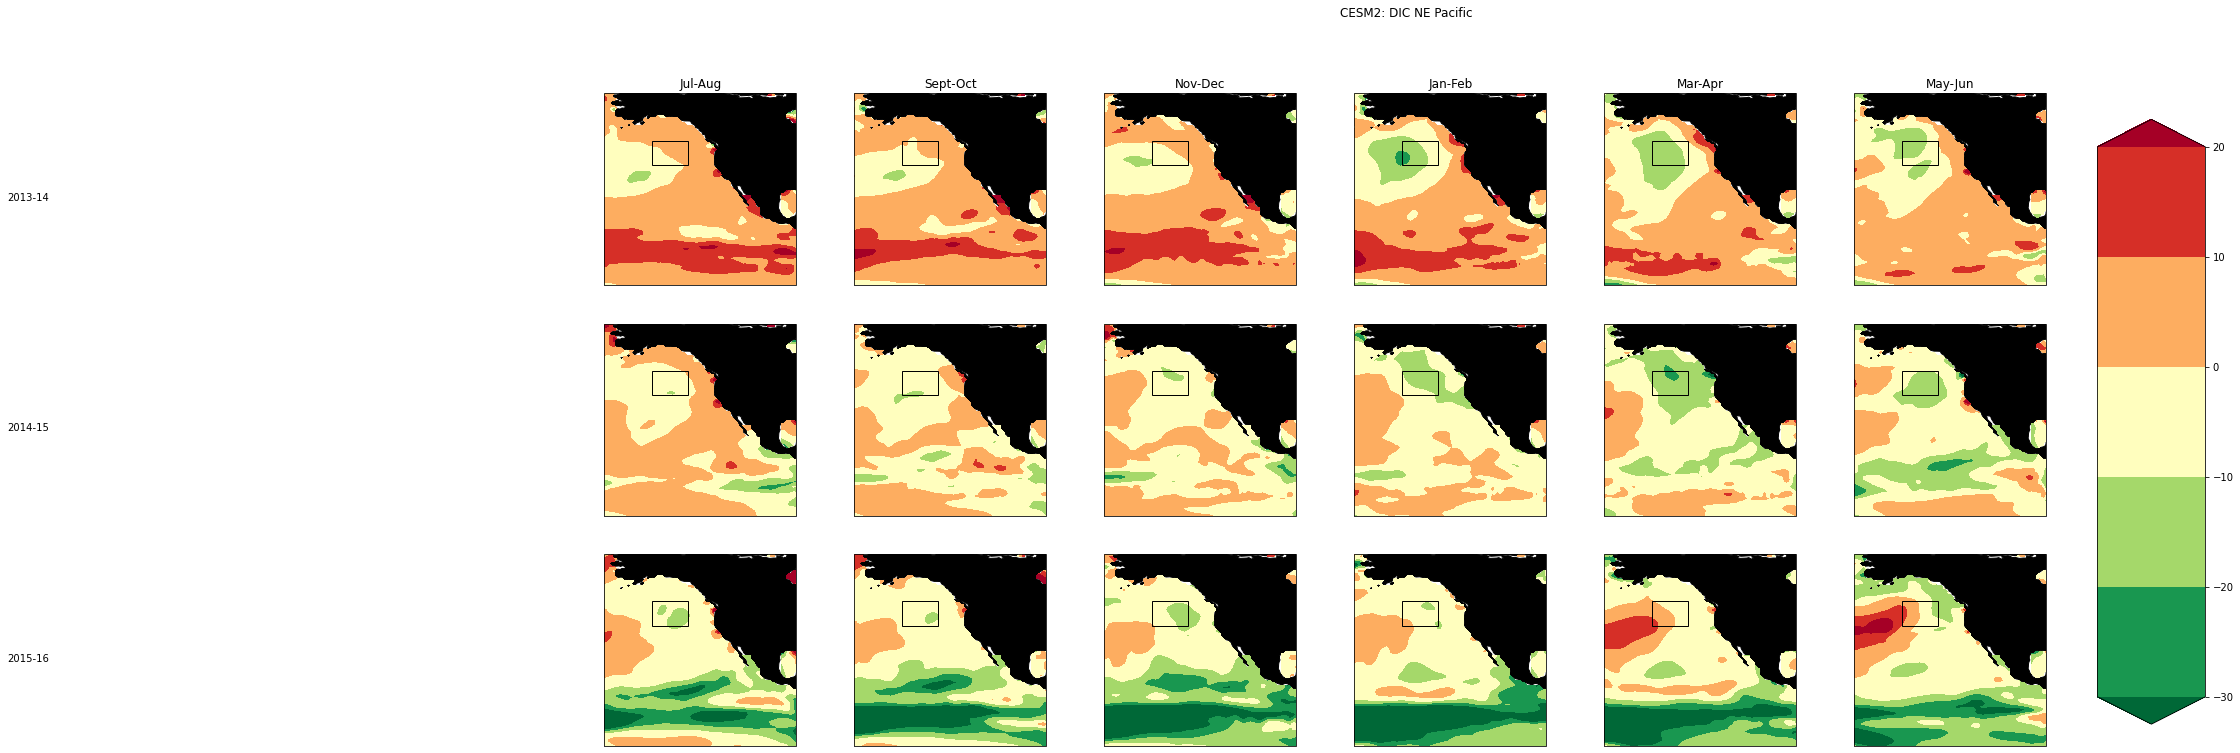

In [12]:
def panels(data,description,variable,depth,lower_bound,upper_bound, step,cmap):
    f, axs = plt.subplots(nrows=3,ncols=6,figsize=(30,12),
                          subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))) 
    axs = axs.flatten()
    for i in range(0,18):
        im = axs[i].contourf(cesm.lon, cesm.lat, cesm.isel(time=i),
                         transform=ccrs.PlateCarree(), 
                         cmap=cmap,
                         levels=np.arange(lower_bound, upper_bound, step),
                         extend='both')
        axs[i].add_feature(cfeature.LAND, color='k')
        axs[i].add_patch(mpatches.Rectangle(xy=[210, 40], width=15, height=10,
                                    edgecolor='k',
                                    facecolor='none',
                                    transform=ccrs.PlateCarree())
                 )
    plt.suptitle("CESM2: " + description + " " + variable + " " + depth)
    axs[0].set_title("Jul-Aug"); axs[1].set_title("Sept-Oct")
    axs[2].set_title("Nov-Dec"); axs[3].set_title("Jan-Feb")
    axs[4].set_title("Mar-Apr"); axs[5].set_title("May-Jun")
    plt.text(-750,215,'2013-14')
    plt.text(-750,120,'2014-15')
    plt.text(-750,25,'2015-16')
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.82, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax,fraction=0.046,pad=0.04)
    
panels(dissic,'DIC','NE','Pacific',-30.0,30.0, 10.0,'RdYlGn_r')